<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/gaussian_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a Gaussian classifier

In this notebook, we will create a Python class implementing a Gaussian classifier. 

The Gaussian classifier implements, in the more general case, the following decision function $g(x)$ for each class $\omega$:

$$\mathrm{g}(x ; \mu, \Sigma)=-\frac{1}{2} x^{T} \Sigma^{-1} x+\mu^{T} \Sigma^{-1} x-\frac{1}{2} \mu^{T} \Sigma^{-1} \mu+\ln p(\omega)-\frac{1}{2} \ln |\Sigma|.$$

Here, we implement a simplified version in the degenerate case in which the covariance matrix is not only isotropic but equal to the identity matrix: $\Sigma=\mathbb{I}$. In this case, it is not difficult to see that the discriminant function $g(x)$ becomes linear and takes the form:

$$\mathrm{g}(x)=\frac{1}{\sigma^{2}} \mu^{T} x-\frac{1}{2 \sigma^{2}} \mu^{T} \mu+\ln p(\omega),$$

with $\sigma=1$.

In the class below, 
- ```fit(x,y)``` estimates the classifier's hyperparameters $\mu, \sigma, p(\omega)$ for each class, from the training data ```x,y``` given as input;
- the (protected) function ```_gk(x, k)``` estimates the value of the discriminant function on the data points ```x``` for class ```k```;
- and ```predict(x)``` returns the predicted labels as well as a matrix with ```shape=(n_samples, n_classes)```, where each element represents the probability that the given point belongs to one class.

In [0]:
import numpy as np


class CClassifierGaussian:
    """
    Class implementing a Gaussian classifier
    (no covariance matrix)
    """

    def __init__(self):
        self._centroids = None
        self._covariances = None
        self._priors = None
        return

    @property
    def centroids(self):
        return self._centroids

    @property
    def covariances(self):
        return self._covariances

    @property
    def priors(self):
        return self._priors

    def fit(self, x, y):
        n_classes = np.unique(y).size
        n_features = x.shape[1]

        priors = np.zeros(shape=(n_classes,))
        centroids = np.zeros(shape=(n_classes, n_features))

        for k in range(n_classes):
            centroids[k] = x[y == k, :].mean(axis=0)
            priors[k] = (y == k).mean()

        # ensure priors sum up to 1
        priors /= priors.sum()

        self._centroids = centroids
        self._priors = priors
        return

    def _gk(self, x, k):
        """
        Computes the value of discriminant function g_k(x) for class k
        :param x:
        :param k:
        :return:
        """
        g = x.dot(self._centroids[k, :])
        g -= 0.5 * np.linalg.norm(self._centroids[k, :], ord=2)**2
        g += np.log(self._priors[k])
        return g

    def predict(self, x):
        n_samples = x.shape[0]
        n_classes = self._centroids.shape[0]
        scores = np.zeros(shape=(n_samples, n_classes))

        for k in range(n_classes):
            scores[:, k] = self._gk(x, k)

        y_pred = np.argmax(scores, axis=1)
        return y_pred, scores




Let's now import some utility functions (whose implementation is discussed in other notebooks): 
- ```make_gaussian_dataset``` to generate a (bi-dimensional) Gaussian dataset;
- ```plot_dataset``` to scatter the data points on a bi-dimensional feature space;
- ```plot_decision_regions``` to display the decision regions and boundaries of a classifier on a bi-dimensional feature space.

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def make_gaussian_dataset(n, mu):
    """
    Creates a k-class d-dimensional Gaussian dataset.
    :param n: vector containing the number of samples for each class
    :param mu: matrix containing the mean vector for each class
    :return: x,y, the gaussian dataset
    """

    n = np.array(n)  # convert to np.array if list is passed as input
    mu = np.array(mu)

    n_classes = mu.shape[0]  # number of classes
    n_features = mu.shape[1]  # number of features
    n_samples = n.sum()  # total number of samples

    # print n_classes, n_features, n_samples

    x = np.zeros(shape=(n_samples, n_features))
    y = np.zeros(shape=(n_samples,))

    start_index = 0
    for i in range(n_classes):
        x_tmp = np.random.randn(n[i], n_features) + mu[i, :]  # broadcasting...
        x[start_index:start_index + n[i], :] = x_tmp
        y[start_index:start_index + n[i]] = i
        start_index += n[i]

    return x, y


def plot_dataset(x, y, feat_1=0, feat_2=1):
    n_classes = len(np.unique(y))
    colors = ['r', 'b', 'g', 'k', 'c', 'm', 'y']

    for y0 in range(n_classes):
        x0 = x[y == y0, feat_1]  # y0 is the selected class within the loop
        x1 = x[y == y0, feat_2]
        plt.scatter(x0, x1, c=colors[y0], label='class ' + str(y0))
    plt.legend()
    plt.xlabel('feature x' + str(feat_1))
    plt.ylabel('feature x' + str(feat_2))

    return


def plot_decision_regions(x, y, classifier, resolution=0.02):
    # setup marker generator and color map
    colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z, score = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    return


Finally, we can generate some data points and test our classifier!

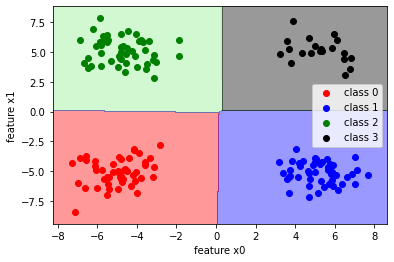

Classification error:  0.0
Centroids:  [[-4.98653505 -5.07251277]
 [ 5.20271702 -5.13533626]
 [-4.75942531  5.11956025]
 [ 5.19759019  5.14653705]]
Priors:  [0.29411765 0.29411765 0.29411765 0.11764706]
Class variances:  None


In [18]:
n_samples = [50, 50, 50, 20]
centroids = [[-5, -5],
             [+5, -5],
             [-5, +5],
             [+5, +5]]

# generate data
x_tr, y_tr = make_gaussian_dataset(n_samples, centroids)
x_ts, y_ts = make_gaussian_dataset(n_samples, centroids)

clf = CClassifierGaussian()
clf.fit(x_tr, y_tr)
plot_decision_regions(x_tr, y_tr, classifier=clf)
plot_dataset(x_tr, y_tr)
plt.show()


y_pred, scores = clf.predict(x_ts)

print('Classification error: ', (y_pred != y_ts).mean())
print('Centroids: ', clf.centroids)
print('Priors: ', clf.priors)
print('Class variances: ', clf.covariances)